# UDD Alpha Controller (Constant CL)

In this tutorial the `UserDefinedDynamic` will be used to implement a PI controller that manipulates the angle of attack to achieve a constant given lift coefficient. The project will be started from an example volume mesh and basic python post-processing of the results will be showcased.

![Mesh](figures/om6_wing_vm.png)

## 1. Imports and Project creation

At first the **flow360** library must be imported.

In [1]:
import flow360 as fl
from flow360.examples import OM6wing

Then the `Project` has to be created. In this case it will be started from the volume mesh.

In [2]:
OM6wing.get_files()

project = fl.Project.from_volume_mesh(
    OM6wing.mesh_filename, name="Tutorial UDD alpha controller from Python"
)

Output()

Output()

[15:27:34] WARNING: The expected mapbc file                                                                        
           c:\Code\Flow360Documentation\.venv\Lib\site-packages\flow360\examples\om6wing\wing_tetra.1.mapbc        
           specifying user-specified boundary names doesn't exist.

[15:27:46] INFO: VolumeMesh successfully submitted:                                                                
                   type        = Volume Mesh                                                                       
                   name        = Tutorial UDD alpha controller from Python                                         
                   id          = vm-70f5a518-3df9-49f1-9b3e-a4d6c5a5a04e                                           
                   status      = uploaded                                                                          
                   project id  = prj-52037feb-d308-4ee7-ab53-d7163a45358f                                          
           

Output()

The project can also be referenced by its unique ID if it was already created.

In [3]:
# project = fl.Project.from_cloud(project_id="prj-your_id_here")

The `Project` entity stores all of the information about the root asset it was created from such as boundary names.

In [4]:
volume_mesh = project.volume_mesh

print("Volume mesh boundaries:")
for boundary in volume_mesh.boundary_names:
    print(f"  - {boundary}")

Volume mesh boundaries:
  - 3
  - 1
  - 2


## 2. Setting up the base of `SimulationParams`

As the project is started from the volume mesh, the `meshing` part is not required. 
The basic case setup consists of:
- setting appropriate operating conditions in `operating_condition`,
- specifying the reference values for coefficient calculation in `reference_geometry`,
- choosing between the transient vs a steady simulation in `time_stepping`,
- setting appropriate boundary conditions in the `models` section,
- specifying wanted outputs in `outputs`.

The `operating_condition` is set using a given *Reynolds number* and *Mach*.

In [5]:
with fl.SI_unit_system:
    operating_condition = fl.AerospaceCondition.from_mach_reynolds(
        reynolds_mesh_unit=11.72e6,
        mach=0.84,
        project_length_unit=0.80167 * fl.u.m,
        temperature=297.78,
        alpha=3.06 * fl.u.deg,
        beta=0 * fl.u.deg,
    )

[15:28:04] INFO: using: SI unit system for unit inference.

[15:28:05] INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

The `reference_geometry` is set according to the input geometry and `time_stepping` is set to `Steady`.

In [6]:
with fl.SI_unit_system:
    reference_geometry = fl.ReferenceGeometry(
        area=1.15315,
        moment_center=[0, 0, 0],
        moment_length=[1.47601, 0.80167, 1.47601],
    )
    time_stepping = fl.Steady(
        max_steps=2000,
    )

           INFO: using: SI unit system for unit inference.

The boundary conditions are assigned to given volume mesh boundaries by specifying them in the models section.

In [7]:
with fl.SI_unit_system:
    models = [
        fl.Wall(surfaces=[volume_mesh["1"]]),
        fl.SlipWall(surfaces=[volume_mesh["2"]]),
        fl.Freestream(surfaces=[volume_mesh["3"]]),
    ]

           INFO: using: SI unit system for unit inference.

For the `outputs` basic `SurfaceOutput` is specified focusing on the pressure coefficient and the wall shear stress.

In [8]:
with fl.SI_unit_system:
    outputs = [
        fl.SurfaceOutput(
            surfaces=volume_mesh["1"],
            output_fields=[
                "Cp",
                "Cf",
                "CfVec",
                "yPlus",
            ],
        )
    ]

           INFO: using: SI unit system for unit inference.

Finally all the fields can be input into the `SimulationParams` class that is used as a setup data source for the simulation.

In [9]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        operating_condition=operating_condition,
        reference_geometry=reference_geometry,
        time_stepping=time_stepping,
        models=models,
        outputs=outputs,
    )

           INFO: using: SI unit system for unit inference.

## 3. Adding `UserDefinedDynamic`

The goal of the `UserDefinedDynamic` object will be to "search" for a specified angle of attach for which the lift coefficient of the wing is a certain value (0.4 in this case). To achieve that the PI controller will be used to update the value of the `alpha` variable in each pseudo_step.

The `UserDefinedDynamic` requires the specification of a few parameters:
- `name` is the name of the dynamic, will be used to access the variables present in it in post-processing,
- `input_vars` is the list of variables from the solution that will be used in calculations ,
- `constants` are the predefined constants used in calculations, in this case those include the CL target and PI controller constants,
- `output_vars` are the variables in the case that are controlled, they are defined using a dictionary where the key is the name of the controlled variable and the value is a formula using the predefined constants, state variables or solution variables such as `pseudo_step`; the formula should be written using C syntax, 
- `state_vars_initial_value` define initial values of the state variables, in this case the initial state of `state[0]` is the `alphaAngle` and the initial state of `state[1]` is `0.0`,
- `update_law` is a list of expression used to calculate the state variables in each `pseudo_step` those expressions also should use C syntax,
- `input_boundary_patches` is a list of boundaries that are used in the calculation of the `input_vars` meaning the `CL` used for calculation will be only taken from the `volume_mesh["1"]` boundary.

The PI controller in this case is formulated so that it does not turn on until 500 pseudo steps, which allows the simulation to converge initially before applying corrections. After this number of steps the `state[0]` calculates the new `alphaAngle` to set and `state[1]` gets the numerical integral part of the controller.

The `state` is a vector of values that can be referenced in the expressions and is updated at each step according to `update_law`.

In [10]:
alpha_controller = fl.UserDefinedDynamic(
    name="alphaController",
    input_vars=["CL"],
    constants={"CLTarget": 0.4, "Kp": 0.2, "Ki": 0.002},
    output_vars={"alphaAngle": "if (pseudoStep > 500) state[0]; else alphaAngle;"},
    state_vars_initial_value=["alphaAngle", "0.0"],
    update_law=[
        "if (pseudoStep > 500) state[0] + Kp * (CLTarget - CL) + Ki * state[1]; else state[0];",
        "if (pseudoStep > 500) state[1] + (CLTarget - CL); else state[1];",
    ],
    input_boundary_patches=[volume_mesh["1"]],
)
params.user_defined_dynamics = [alpha_controller]

## 4. Running the simulation

The simulation is then run using the `run_case` function of the `Project`.

In [11]:
case = project.run_case(
    params=params, name="Case of tutorial UDD alpha controller from Python"
)

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

           INFO: using: SI unit system for unit inference.

[15:28:07] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Case of tutorial UDD alpha controller from Python                                 
                   id          = case-79b42c52-01a4-44fd-b410-3c6c67082df0                                         
                   status      = pending                                                                           
                   project id  = prj-52037feb-d308-4ee7-ab53-d7163a45358f                                          
           

## 5. Post-processing

To access the results of the simulation it has to be finished. They can be found in the `results` parameter. Below the state of the controller and calculated alpha is plotted.

Output()

Output()

[15:29:27] INFO: Saved to C:\Users\user\AppData\Local\Temp\tmpvdihtq8f\1eba06e3-b226-42da-9f23-b992ec6362e3.csv

<Axes: xlabel='pseudo_step', ylabel='CL - orange'>

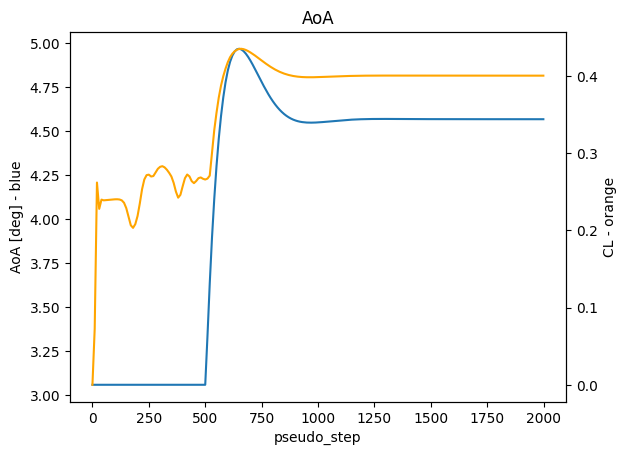

In [12]:
case.wait()

udd_data = case.results.user_defined_dynamics["alphaController"]

ax0 = udd_data.as_dataframe().plot(
    x="pseudo_step",
    y="alphaAngle",
    title="AoA",
    ylabel="AoA [deg] - blue",
    legend=False,
)
ax1 = ax0.twinx()
udd_data.as_dataframe().plot(
    x="pseudo_step", y="CL", ylabel="CL - orange", ax=ax1, color="orange", legend=False
)

<Axes: xlabel='pseudo_step', ylabel='state[1] - orange'>

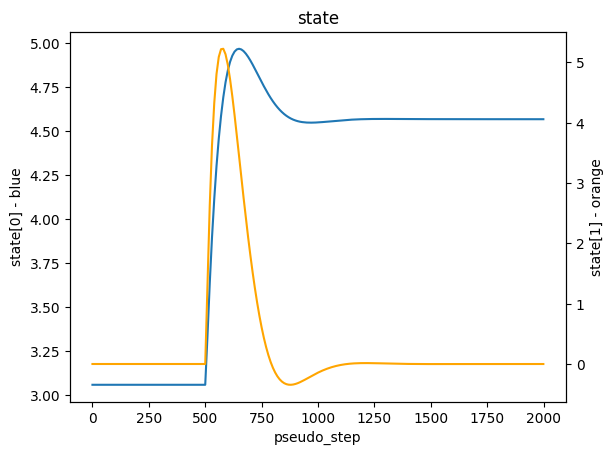

In [13]:
ax0 = udd_data.as_dataframe().plot(
    x="pseudo_step", y="state[0]", title="state", ylabel="state[0] - blue", legend=False
)
ax1 = ax0.twinx()
udd_data.as_dataframe().plot(
    x="pseudo_step",
    y="state[1]",
    ylabel="state[1] - orange",
    ax=ax1,
    color="orange",
    legend=False,
)